In [1]:
# Purpose is to change the global coupling (gain) and change the thalamoconnectivity 
# First try changing the gain and compare the FC and SC and plot it as a function of global variability

%pylab nbagg
from tvb.simulator.lab import *
from tvb.simulator.plot.phase_plane_interactive import PhasePlaneInteractive
import numpy as np
import matplotlib.pyplot as plt
import tvb.analyzers.correlation_coefficient as corr_coeff
from tvb.datatypes.time_series import TimeSeriesRegion
import time

# to get an estimate of simulation time use: tic=time.time()
#tic-time.time() 
# Bezgin 2017 Human Brain Mapping for information on the 96 parcellation

Populating the interactive namespace from numpy and matplotlib
   INFO  log level set to INFO


In [40]:
def run_sim(conn, gain, D, dt=0.5, simlen=1e3):
    """
    Run a single instance of the simulation.
    Returns a list of pairs (times, values). There will be one entry
    in the list for each output monitor used.
    """
    mon_raw = monitors.Raw()
    mon_tavg = monitors.TemporalAverage(period=5.0)#period=2**-2)

    #Bundle them
    what_to_watch = (mon_tavg, mon_raw)
    
    
    sim = simulator.Simulator(
        
        model=models.Generic2dOscillator(a=0.0),
        # Change the Conn matrix here; make it twice as large three times as large
        connectivity=conn,  # use the connectivity structure defined below
        coupling=coupling.PreSigmoidal(H=gain,theta=0.0,dynamic=False), # parameters?
        #coupling=coupling.Linear(a=gain),
        integrator=integrators.HeunStochastic(dt=dt,
                           noise=noise.Additive(nsig=np.array([D]))),
        monitors = what_to_watch
    )
    sim.configure()
    
    #Perform the simulation
    res = sim.run(simulation_length=simlen)
    (tavg_time,tavg_dat),(raw_time,raw_dat) = res
    
    return sim,tavg_time,tavg_dat,raw_time,raw_dat

#conn = connectivity.Connectivity(load_default=True)
conn=connectivity.Connectivity.from_file('connectivity_96.zip')
conn.configure()

WARNING  File 'hemispheres' not found in ZIP.


In [41]:
# Run the simulation

# using the gain parameter specified on the command line,
# run one instance of the simulation
# the label is there simply to allow running multiple of these in parallel
# without clobbering each other's output files
burnin=500
d = {}
g=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.8,1]
raw_show={}
tic=time.time()
for i in range(len(g)):
    sim,tavg_time,tavg_dat,raw_time,raw_dat = run_sim(conn, g[i], 5e-4, simlen=1e4)
    # reshape the data which are output with some empty dimensions
    raw_timep=raw_time[burnin:,]
    raw = raw_dat
    # calculate global variance
    raw = raw[:,0,:,0]
    simdata=raw[burnin:,:] # remove the burnin period
    g[i]=round(g[i],2)
    VAR=np.var(simdata)
    d[g[i]] = VAR
    raw_show[g[i]]=raw_dat[burnin:,:,:,:]
'simulation required %0.3f seconds.' % (time.time() - tic, )
print(d)
print(simdata.shape)

{0.0: 0.032092547711753794, 0.5: 2.3623188237514525, 0.2: 1.5323575099371556, 0.4: 2.0683198830776925, 1.0: 3.5406047589245735, 0.8: 3.1167424733459113, 0.6: 2.6336981210741968, 0.3: 1.7512524256982547, 0.1: 1.3264428533194479}
(19500, 96)


<IPython.core.display.Javascript object>


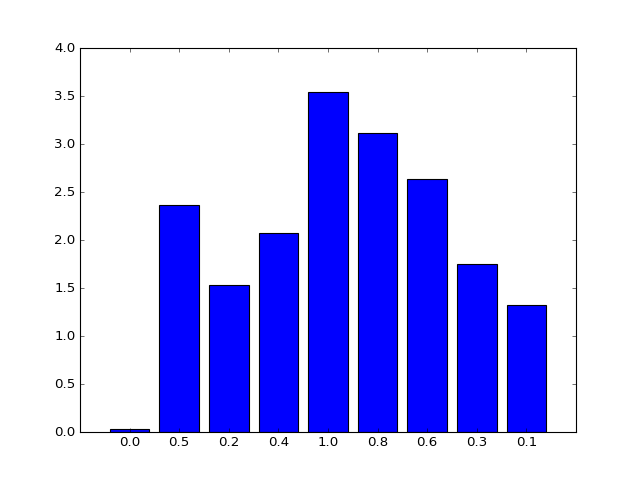

In [42]:
# now plot as a function of gain
figure()
plt.bar(range(len(g)), d.values(), align='center')
plt.xticks(range(len(d)), d.keys())
show()

<IPython.core.display.Javascript object>


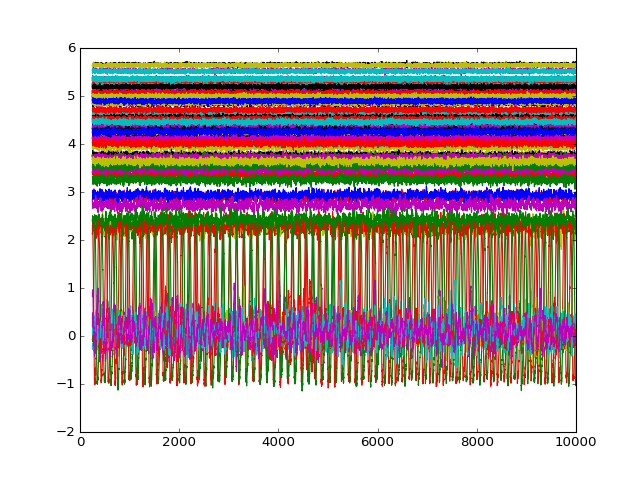

In [43]:
# choose data for which coupling you want to visualize (show time series) and compute correlation coefficient
RAW=raw_show[0.4]
figure()
plot(raw_timep, RAW[:,0,:,0])
show()

In [44]:
def compare_con(gain,RAW):
    data_show=RAW[gain]
    # compute functional connectivity using analyzer
    tsr = TimeSeriesRegion(connectivity=sim.connectivity,
                           data=data_show,
                           sample_period=sim.monitors[0].period)
    tsr.configure()
    corrcoeff_analyser = corr_coeff.CorrelationCoefficient(time_series=tsr)
    corrcoeff_data = corrcoeff_analyser.evaluate()
    corrcoeff_data.configure()
    FC = corrcoeff_data.array_data[..., 0, 0]
    # plot
    figure(figsize=(10, 4))
    subplot(121), imshow(conn.weights, cmap='binary', interpolation='none')
    subplot(122), imshow(FC, cmap='gray', interpolation='none');
    show()
    return

   INFO  result shape will be: (96, 96, 1, 1)


<IPython.core.display.Javascript object>


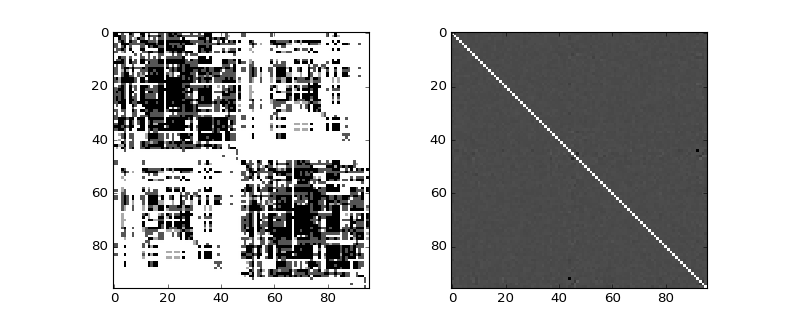

In [47]:
compare_con(0.6,raw_show)

<IPython.core.display.Javascript object>


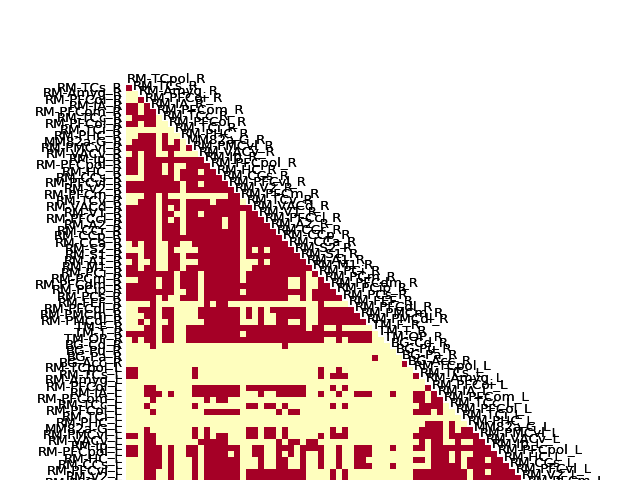

In [145]:
#Figure()
#plot_tri_matrix(sim.connectivity.weights,
#                cmap=pyplot.cm.RdYlBu_r, 
#                node_labels= sim.connectivity.region_labels,
#                size=[10., 10.],
#                color_anchor=(-1.0, 1.0));
#show()